# Simple classification with pytorch

## Data processing

### Create a csv file 

In [1]:
import os
import glob
import yaml
import pandas as pd

def make_csv_path(excluded_labels=None):
    list_images = glob.glob('../data/raw/**/*.jpg', recursive=True)
    df = pd.DataFrame({'path': list_images})
    df['label'] = df['path'].apply(lambda x:os.path.basename(os.path.dirname(x)))
    if excluded_labels is not None:
        df = df[~df['label'].isin(excluded_labels)]
        print('Csv file constituted with {nrows} images, representing {nclasses} classes, excluding {exclusion}'.format(
        nrows=df.shape[0],
        nclasses=len(df['label'].unique()),
        exclusion= ','.join(excluded_labels)
        ))
    else:
        print('Csv file constituted with {nrows} images, representing the {nclasses} classes'.format(
            nrows=df.shape[0],
            nclasses=len(df['label'].unique())
        ))
    
    # Converting classes to number 
    labels = df['label'].unique()
    labels.sort()
    labels_map = {label:i for i, label in enumerate(labels)}
    df['y'] = df['label'].map(labels_map)

    labels_map_save = {i:label for i, label in enumerate(labels)}
    # Saving the map numbers -> label
    with open("../data/processed/labels_map.yaml", "w") as outfile:
        yaml.dump(labels_map_save, outfile)

    df.to_csv('../data/interim/filepath.csv', index=False)

make_csv_path(excluded_labels=['Corals', 'Crabs'])

Csv file constituted with 10701 images, representing 17 classes, excluding Corals,Crabs


### Creating a Custom Dataset class for the files 

In [2]:
# Modules

import torch
import numpy as np
from torch.utils.data import Dataset
from torchvision.io import read_image
import torchvision.transforms as T

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, transform=None, target_transform=None):
        filepath_df = pd.read_csv(annotations_file)
        self.img_labels = filepath_df['y']
        self.img_dir = filepath_df['path']
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir[idx])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

image_size = (227,227)

transformf = T.Compose([
    T.ToPILImage(),
    T.Resize(size=image_size),
    T.ToTensor()
])

dataset = CustomImageDataset(annotations_file='../data/interim/filepath.csv', transform=transformf)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4)



/home/aurelien/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def get_mean_and_std(loader):
    mean = 0. 
    std = 0. 
    total_images_count = 0

    for images,_ in loader:
        image_count_batch = images.size(0)
        images = images.view(image_count_batch, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += image_count_batch
    
    mean /= total_images_count
    std /= total_images_count
    return mean, std
mean, std = get_mean_and_std(dataloader)

dict_mean_std = {'mean': mean.tolist(),
'std': std.tolist()}

print(dict_mean_std)

with open("../data/processed/image_mean_std.yaml", "w") as outfile:
    yaml.dump(dict_mean_std, outfile)

{'mean': [0.305789053440094, 0.4046460688114166, 0.42739832401275635], 'std': [0.1787707507610321, 0.1817948818206787, 0.180245041847229]}


### Plot some images for verification

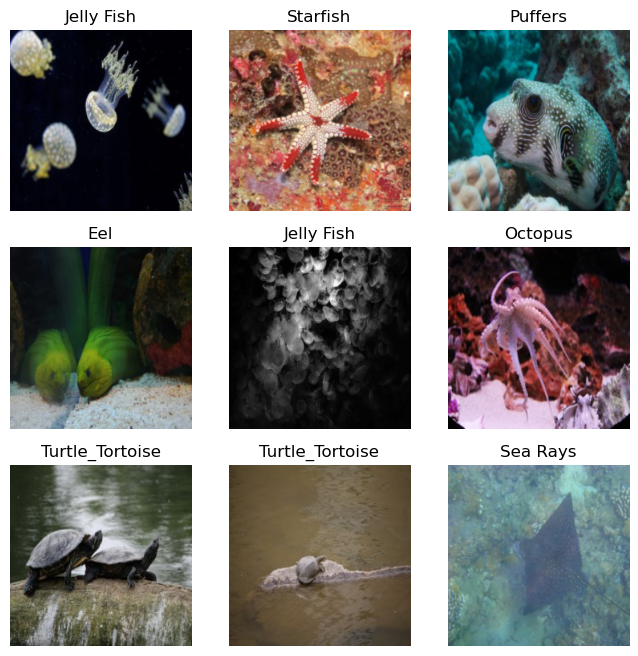

In [4]:
# Modules
import torch
import matplotlib.pyplot as plt 

# Scripts
label_map = yaml.safe_load(open('../data/processed/labels_map.yaml'))
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(dataset.__len__(), size=(1,)).item()
    img, y = dataset.__getitem__(sample_idx)
    figure.add_subplot(rows, cols, i)
    plt.title(label_map[y])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))
plt.show()

### Split the dataset + data augmentation

+ Track the files with dvc 
+ Data augmentation parameters for training data, test data ? 

In [5]:
# Modules
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Script

def split_dataset(annotations_file, output_folder, test_split=0.2, val_split=0.2, random_seed=99):
    dataset = pd.read_csv(annotations_file)
    train, test = train_test_split(dataset, stratify=dataset['label'], test_size=test_split, random_state=random_seed)
    train, val = train_test_split(train, stratify=train['label'], test_size=val_split, random_state=random_seed)
    train.to_csv(os.path.join(output_folder, 'train.csv'), index=False)
    train.to_csv(os.path.join(output_folder, 'val.csv'), index=False)
    test.to_csv(os.path.join(output_folder, 'test.csv'), index=False)


split_dataset(annotations_file='../data/interim/filepath.csv', output_folder='../data/processed', val_split=0.2, random_seed=99)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([64, 3, 227, 227])
Labels batch shape: torch.Size([64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


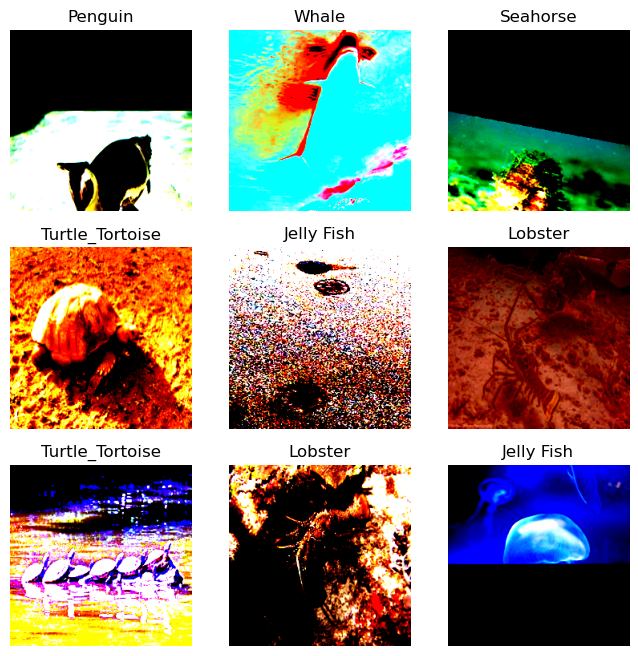

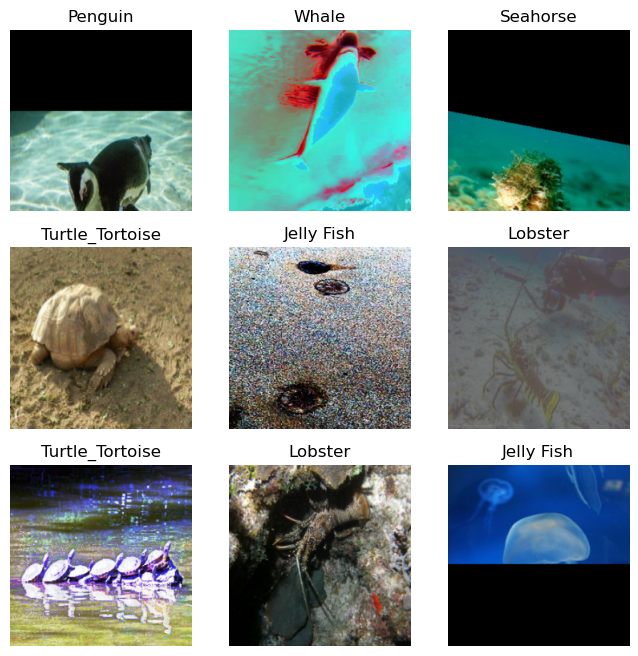

In [6]:
# Modules
import yaml
import pandas as pd
import torchvision.transforms as T
from torch.utils.data import DataLoader

# Dependencies
mean_std = yaml.safe_load(open('../data/processed/image_mean_std.yaml'))

# Parameters
policies = [T.AutoAugmentPolicy.CIFAR10, T.AutoAugmentPolicy.IMAGENET, T.AutoAugmentPolicy.SVHN]
image_size = (227,227)

# Scripts 
train_T=T.Compose([
    T.AutoAugment(policies[0]),
    T.ToPILImage(),
    T.Resize(size=image_size),
    T.ToTensor(),
    T.Normalize(mean=mean_std['mean'], std=mean_std['std']),
    #T.ConvertImageDtype(torch.float)
    ])

train_dataset = CustomImageDataset(annotations_file='../data/processed/train.csv', transform=train_T)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_T=T.Compose([
    T.ToPILImage(),
    T.Resize(size=image_size),
    T.ToTensor(),
    T.Normalize(mean=mean_std['mean'], std=mean_std['std']),
    #T.ConvertImageDtype(torch.float)
    ])

val_dataset = CustomImageDataset(annotations_file='../data/processed/val.csv', transform=val_T)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

test_dataset = CustomImageDataset(annotations_file='../data/processed/test.csv', transform=val_T)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

label_map = yaml.safe_load(open('../data/processed/labels_map.yaml'))

denorm = T.Normalize(
    mean=[-m / s for m, s in zip(mean_std['mean'], mean_std['std'])],
    std=[1.0 / s for s in mean_std['std']])

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    img = train_features[i].squeeze()
    y = train_labels[i]
    figure.add_subplot(rows, cols, i)
    plt.title(label_map[y.item()])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))
plt.show()

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    img = train_features[i].squeeze()
    y = train_labels[i]
    figure.add_subplot(rows, cols, i)
    plt.title(label_map[y.item()])
    plt.axis("off")
    plt.imshow(denorm(img).permute(1, 2, 0))
plt.show()


## Training the network


In [26]:
import torchvision
from torch import nn
import pytorch_lightning as pl
from torchmetrics.functional import accuracy
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torch.optim import Adam
# Define the LightningModule

class mobilenetv3_fe(pl.LightningModule):

    def __init__(self, num_classes=17):
        super().__init__()

        # Parameters
        self.lr = 0.001
        self.num_classes = num_classes

        # Init a pretrained mobilenetv3 model
        
        self.model = torchvision.models.mobilenet_v3_small(weights='IMAGENET1K_V1', pretrained=True, progress=True)
        
        # Feature extraction : freeze the network
        for param in self.model.parameters():
                param.requires_grad = False
        
        # Replacing last layer with new layer (not frozen)
        num_ftrs = self.model.classifier[-1].in_features
        self.model.classifier[3] = nn.Linear(num_ftrs, self.num_classes)


    def forward(self, x):
        out = self.model(x)
        return out
    
    def loss_fn(self, out, target):
        return nn.CrossEntropyLoss()(out.view(-1, self.num_classes), target)
    
    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        images, labels = batch
        label = labels.view(-1)
        img = images.view(-1, 3, images.size(2), images.size(2))
        out = self(img)
        loss = self.loss_fn(out, label)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self,batch,batch_idx):
        images, labels = batch
        label = labels.view(-1)
        img = images.view(-1, 3, images.size(2), images.size(2))
        out = self(img)
        loss = self.loss_fn(out, label)
        out = nn.Softmax(-1)(out) 
        logits = torch.argmax(out, dim=1)
        accu = accuracy(logits, label, task='multiclass', num_classes=self.num_classes)
        self.log("valid_loss", loss, prog_bar=True)
        self.log("val_acc", accu, prog_bar=True)
    
    def test_step(self, batch, batch_idx):
        images, labels = batch
        label = labels.view(-1)
        img = images.view(-1, 3, images.size(2), images.size(2))
        out = self(img)
        out = nn.Softmax(-1)(out) 
        logits = torch.argmax(out,dim=1)
        accu = accuracy(logits, label, task='multiclass', num_classes=self.num_classes)  
        self.log("test_acc", accu)

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        images, labels = batch
        label = labels.view(-1)
        img = images.view(-1, 3, images.size(2), images.size(2))
        out = self(img)
        out = nn.Softmax(-1)(out) 
        return torch.argmax(out,dim=1)


class LightDataset(pl.LightningDataModule):
    def __init__(self, batch_size=16):
        super().__init__()
        self.batch_size = batch_size

        self.train_T=T.Compose([
            T.AutoAugment(policies[0]),
            T.ToPILImage(),
            T.Resize(size=image_size),
            T.ToTensor(),
            T.Normalize(mean=mean_std['mean'], std=mean_std['std']),
            #T.ConvertImageDtype(torch.float)
            ])

        self.val_T=T.Compose([
            T.ToPILImage(),
            T.Resize(size=image_size),
            T.ToTensor(),
            T.Normalize(mean=mean_std['mean'], std=mean_std['std']),
            #T.ConvertImageDtype(torch.float)
            ])

    def train_dataloader(self):
        train_dataset = CustomImageDataset(annotations_file='../data/processed/train.csv', transform=self.train_T)
        train_loader = DataLoader(train_dataset,
                            batch_size=self.batch_size,
                            shuffle=True, num_workers=8)
        return train_loader
    
    def val_dataloader(self):
        val_dataset = CustomImageDataset(annotations_file='../data/processed/val.csv', transform=self.val_T)
        valid_loader = DataLoader(val_dataset,
                            batch_size=self.batch_size,
                            shuffle=False, num_workers=8)       
        return valid_loader
    
    def test_dataloader(self):
        test_dataset = CustomImageDataset(annotations_file='../data/processed/test.csv', transform=self.val_T)
        test_loader = DataLoader(test_dataset,
                            batch_size=self.batch_size,
                            shuffle=False, num_workers=8)       
        return test_loader

In [ ]:
import mlflow.pytorch
from mlflow import MlflowClient

mlflow.set_tracking_uri("../mlruns")
tracking_uri = mlflow.get_tracking_uri()
print("Current tracking uri: {}".format(tracking_uri))

def print_auto_logged_info(r):
    tags = {k: v for k, v in r.data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in MlflowClient().list_artifacts(r.info.run_id, "model")]
    print("run_id: {}".format(r.info.run_id))
    print("artifacts: {}".format(artifacts))
    print("params: {}".format(r.data.params))
    print("metrics: {}".format(r.data.metrics))
    print("tags: {}".format(tags))

# Initialize a trainer
trainer = pl.Trainer(accelerator='gpu', devices=-1, max_epochs=5)
model = mobilenetv3_fe()
dx = LightDataset(batch_size=32)

# Auto log all MLflow entities
mlflow.pytorch.autolog()

with mlflow.start_run() as run:
    trainer.fit(model, dx)
    trainer.test(model, dx)

# fetch the auto logged parameters and metrics
print_auto_logged_info(mlflow.get_run(run_id=run.info.run_id))

## Predict and evaluate on test set

In [ ]:
from sklearn.metrics import classification_report

test_dataloader = LightDataset(batch_size=1).test_dataloader()
pred = trainer.predict(model, test_dataloader)
y_pred = list(map(lambda x: x.item(), pred))

y_true = []
for test_data in test_dataloader:
    y_true.append(test_data[1].item())


print(classification_report(y_true, y_pred, digits=4, target_names=label_map.values()))